# Parameter Tuning
    Find best size for test set

In [1]:
!pip install pandas
!pip install sklearn

import pandas as pd;
import numpy as np;
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler;
from sklearn import metrics;
from sklearn.model_selection import TimeSeriesSplit;
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import LinearRegression

# empty list to append metric values
mae_cv = []
mse_cv = []
mae_gen = []
mse_gen  =[]
rmse_gen = []
mae_nor = []
mae_spi = []
mse_nor = []
mse_spi = []
rmse_nor = []
rmse_spi = []

In [2]:
test_set_range = [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]


for i in test_set_range:
    # import data
    data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)

    # 2018 data
    data = data.loc[data.index > 2018100000, :]

    # reset index
    data.reset_index(inplace = True)
    data.drop('index', axis = 1, inplace = True)

    # Divide features and labels
    X = data.iloc[:, 0:15]
    y = data.loc[:, 'Offers']
    
    X.fillna(X.mean(), inplace = True)
    y.fillna(y.mean(), inplace = True)

    X = X.round(20)
    
    # divide data into train and test with X test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = i, shuffle=False)

    # feature scaling
    sc_X = MinMaxScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)
    
    # create time series split for CV
    splits = 7
    tscv = TimeSeriesSplit(n_splits = splits)
    
    # create linear regressor 
    regressor = LinearRegression()
    
    for train_index, test_index in tscv.split(X_train):
          X_train_split, X_test_split = X_train[train_index], X_train[test_index]
          y_train_split, y_test_split = y_train[train_index], y_train[test_index]
          regressor.fit(X_train_split, y_train_split)
    
    # predict for X_test  
    y_pred = regressor.predict(X_test)

    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mse_error = mse(y_test, y_pred) # 1479.61335
    mae_error = mae(y_test, y_pred) # 23.1525
    
    rmse_gen.append(rmse_error)
    mse_gen.append(mse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])
    
    # create array same size as y_test
    y_spike_occ = y_spike_occ.iloc[- len(y_test):]
    y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values
    
    
    # smal adjustment
    y_test.replace(0, 0.0001,inplace = True)

    
    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mse_spike = mse(y_test_spike, y_pred_spike)
    mae_spike = mae(y_test_spike, y_pred_spike)
    
    rmse_spi.append(rmse_spike)
    mse_spi.append(mse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================
    
    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)
    
    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mse_normal = mse(y_test_normal, y_pred_normal)
    mae_normal = mae(y_test_normal, y_pred_normal)
    
    rmse_nor.append(rmse_normal)
    mse_nor.append(mse_normal)
    mae_nor.append(mae_normal)

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\maria\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\maria\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(ne

In [3]:
data.head()

,Ren_R,APXP,Rene,TSDF,NIV,Im_Pr,In_gen,LOLP,PrevDay,PrevWeek,DA_margin,DA_imb,DA_price_france,ratio_offers_vol,DA_imb_France,Offers
0,0.729581,49.00,10379.138,21302.0,-173.0882,55.33220,1204.0,0.0,91.0,158.5,32390.0,-381.0,51.61,0.019201,0.774709,92.5
1,0.736864,54.19,10107.092,21117.0,-21.8796,43.18000,822.0,0.0,91.0,158.5,32259.0,34.0,69.13,0.015190,0.782172,92.5
2,0.751204,54.19,10107.092,21150.0,-25.4302,43.18000,594.0,0.0,220.0,158.5,31070.0,317.0,69.13,0.014307,0.782172,92.5
3,0.743394,60.94,9823.762,21713.0,156.0437,76.00000,908.0,0.0,160.0,158.5,29577.0,1431.0,77.32,0.017871,0.852149,180.0
4,0.743207,60.94,9823.762,21715.0,494.8151,81.91105,982.0,0.0,160.0,158.5,27346.0,2266.0,77.32,0.018758,0.852149,92.5


In [4]:
results = pd.DataFrame({                       
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor}, index = test_set_range)

results

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
0.050,34.658410,27.810347,69.829460,58.619998,27.064034,23.880544
0.075,34.388820,27.949086,60.410529,50.392623,26.320808,23.492787
0.100,32.572334,25.923701,60.921518,49.965948,24.742663,21.853056
0.125,32.220094,25.935097,58.589210,47.848708,25.044029,22.174499
0.150,31.214067,24.834202,58.257282,47.165324,24.175838,21.236193
0.175,31.849245,25.010666,62.639700,50.746643,23.932729,21.104312
0.200,32.882612,25.605291,65.926997,53.215877,24.250765,21.434942
0.225,34.280256,26.845782,68.498522,55.608901,25.701455,22.637354
0.250,34.277304,26.964916,67.433237,54.895676,25.954664,22.813046


In [5]:
!pip install matplotlib

%matplotlib notebook

import matplotlib.pyplot as plt

In [6]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
0.05,34.658410,27.810347,69.829460,58.619998,27.064034,23.880544
0.075,34.388820,27.949086,60.410529,50.392623,26.320808,23.492787
0.1,32.572334,25.923701,60.921518,49.965948,24.742663,21.853056
0.125,32.220094,25.935097,58.589210,47.848708,25.044029,22.174499
0.15,31.214067,24.834202,58.257282,47.165324,24.175838,21.236193
0.175,31.849245,25.010666,62.639700,50.746643,23.932729,21.104312
0.2,32.882612,25.605291,65.926997,53.215877,24.250765,21.434942
0.225,34.280256,26.845782,68.498522,55.608901,25.701455,22.637354
0.25,34.277304,26.964916,67.433237,54.895676,25.954664,22.813046


<IPython.core.display.Javascript object>


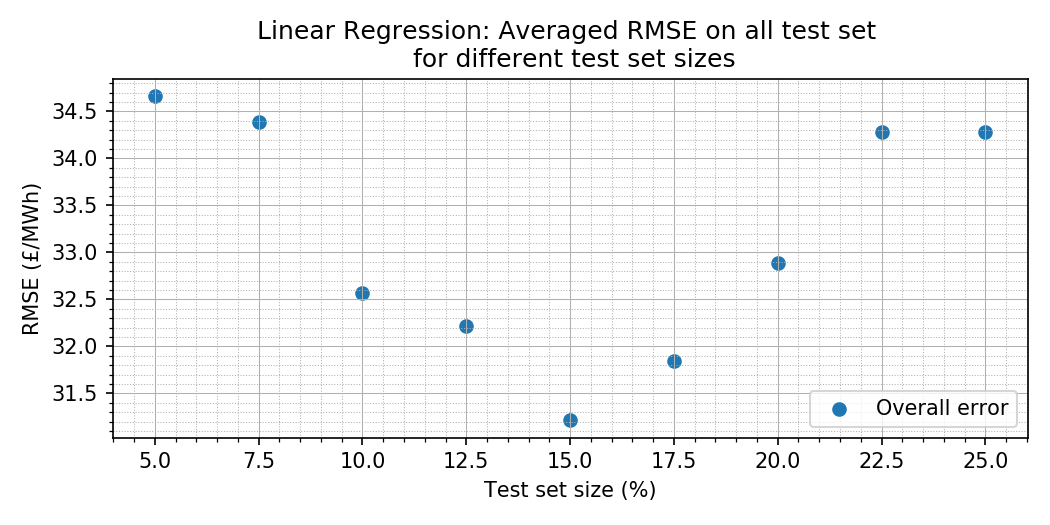

<IPython.core.display.Javascript object>


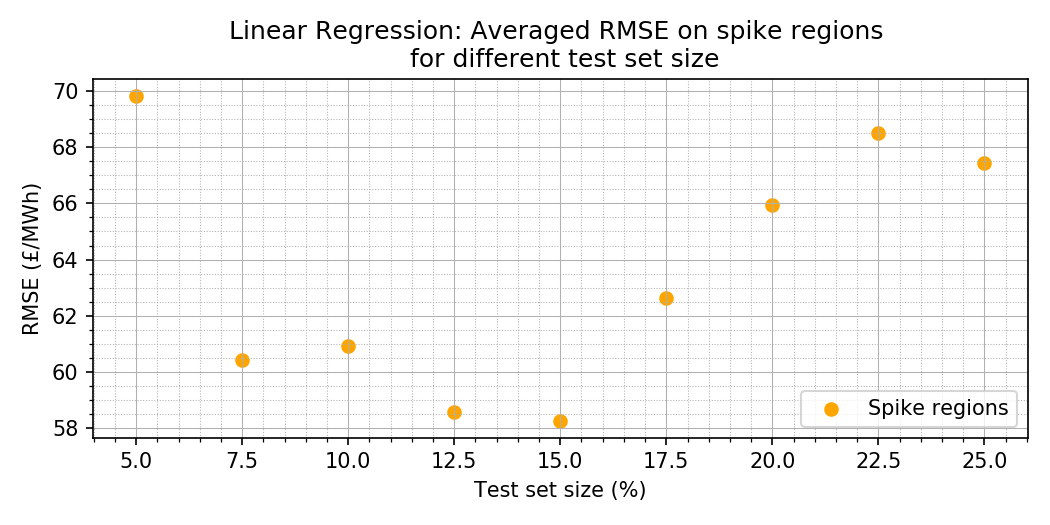

<IPython.core.display.Javascript object>


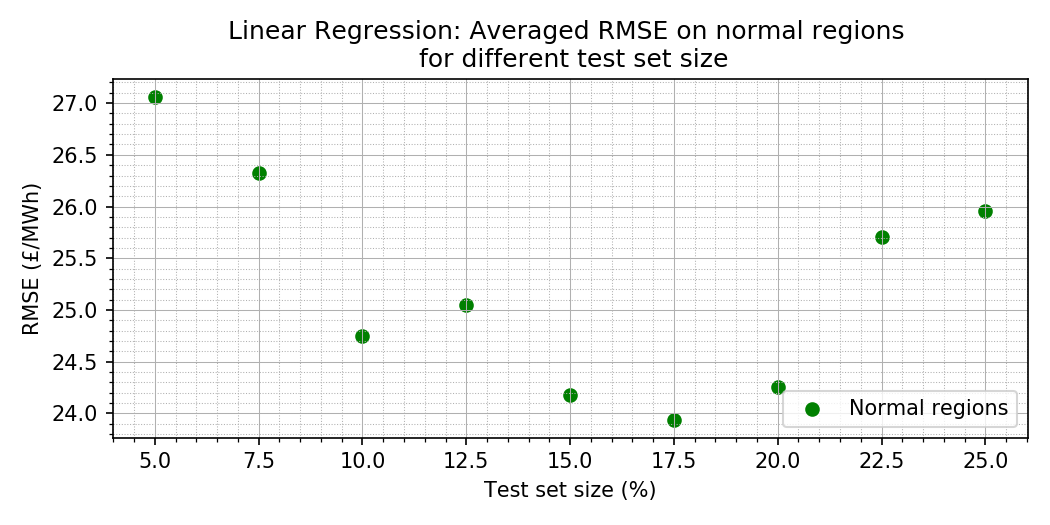

In [9]:
plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Linear Regression: Averaged RMSE on all test set \n for different test set sizes')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y = rmse_gen, label = 'Overall error')
plt.legend(loc = 'lower right')
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(i * 100)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('RMSE_best_test_set_all.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Linear Regression: Averaged RMSE on spike regions \n for different test set size')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y =rmse_spi, label = 'Spike regions', color = 'orange')
plt.legend(loc = 'lower right')
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(i * 100)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('RMSE_best_test_set_spike.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Linear Regression: Averaged RMSE on normal regions \n for different test set size')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y =rmse_nor, label = 'Normal regions', color = 'green')
plt.legend(loc = 'lower right')
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(i * 100)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('RMSE_best_test_set_normal.png')

<IPython.core.display.Javascript object>


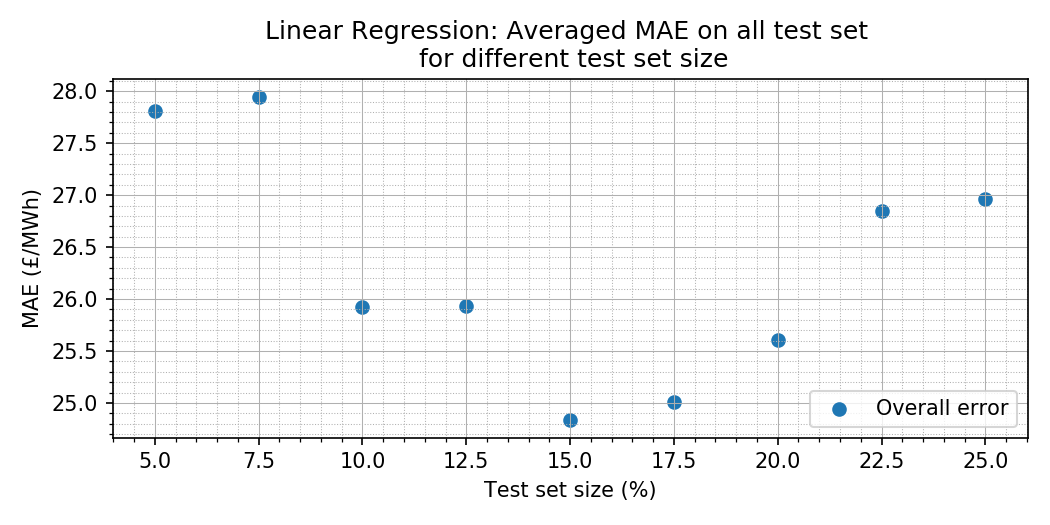

<IPython.core.display.Javascript object>


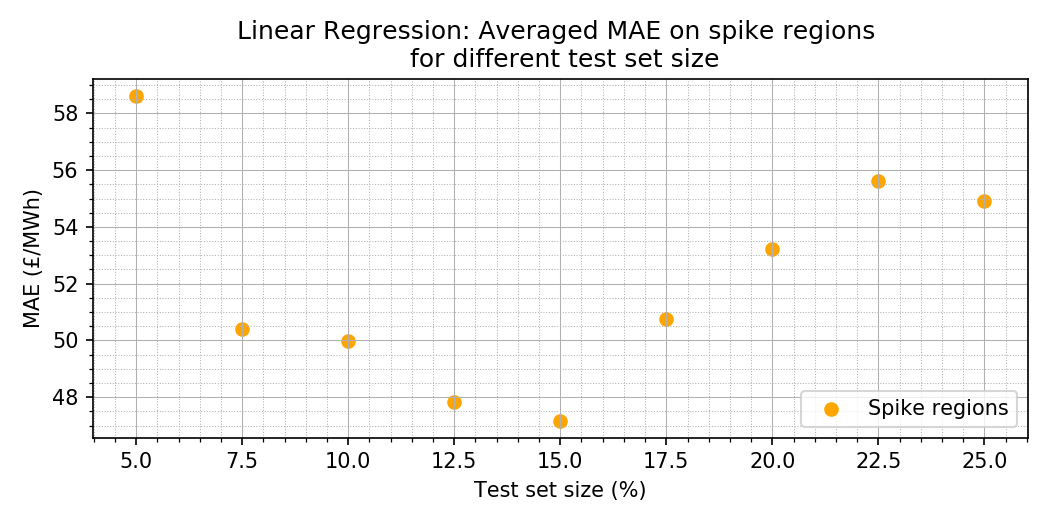

<IPython.core.display.Javascript object>


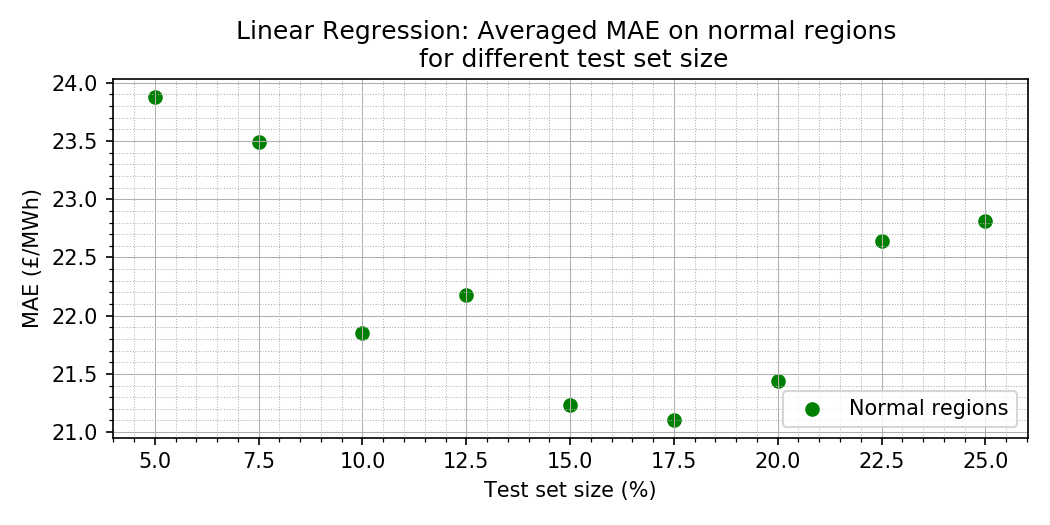

In [10]:
plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Linear Regression: Averaged MAE on all test set \n for different test set size')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y = mae_gen, label = 'Overall error')
plt.legend(loc = 'lower right')
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(i * 100)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('MAE_best_test_set_all.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Linear Regression: Averaged MAE on spike regions \n for different test set size')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y =mae_spi, label = 'Spike regions', color = 'orange')
plt.legend(loc = 'lower right')
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(i * 100)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('MAE_best_test_set_spike.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Linear Regression: Averaged MAE on normal regions \n for different test set size')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y = mae_nor, label = 'Normal regions', color = 'green')
plt.legend(loc = 'lower right')
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(i * 100)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('MAE_best_test_set_normal.png')